In [36]:
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import gzip
import pickle
import os
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.data import TensorDataset
import pickle
import time
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd

In [37]:
learning_rate = 0.001
batch_size = 64
num_epochs = 25
dropout_rate1 = 0.25
dropout_rate2 = 0.5
num_classes = 10
input_shape = (1, 28, 28)
train_fraction = 0.15
test_fraction  = 0.15
seed = 13

In [3]:
np.random.seed(seed)
torch.manual_seed(seed)

## Functions

In [4]:
def im2col(x, KH, KW, padding):
    B, C, H, W = x.shape
    H_out = H + 2 * padding - KH + 1
    W_out = W + 2 * padding - KW + 1

    x_padded = np.pad(x, ((0, 0), (0, 0), (padding, padding), (padding, padding)))
    cols = np.zeros((B, C * KH * KW, H_out * W_out))

    for i in range(H_out):
        for j in range(W_out):
            patch = x_padded[:, :, i:i+KH, j:j+KW]
            cols[:, :, i * W_out + j] = patch.reshape(B, -1)

    return cols, H_out, W_out

In [5]:
def col2im(dcols, x_shape, KH, KW, padding):
    B, C, H, W = x_shape
    H_out = H + 2 * padding - KH + 1
    W_out = W + 2 * padding - KW + 1

    dx_padded = np.zeros((B, C, H + 2 * padding, W + 2 * padding))

    for i in range(H_out):
        for j in range(W_out):
            patch = dcols[:, :, i * W_out + j].reshape(B, C, KH, KW)
            dx_padded[:, :, i:i+KH, j:j+KW] += patch

    if padding > 0:
        return dx_padded[:, :, padding:-padding, padding:-padding]
    return dx_padded

In [6]:
def pad2d(x, padding):
    return np.pad(x, ((0, 0), (0, 0), (padding, padding), (padding, padding)))

In [7]:
class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.padding = padding
        self.weight = np.random.randn(out_channels, in_channels, *self.kernel_size) * 0.01
        self.bias = np.zeros((out_channels, 1))
        self.d_weight = np.zeros_like(self.weight)
        self.d_bias = np.zeros_like(self.bias)

    def forward(self, x):
        self.x = x
        KH, KW = self.kernel_size
        B = x.shape[0]
        self.cols, self.H_out, self.W_out = im2col(x, KH, KW, self.padding)
        W_col = self.weight.reshape(self.out_channels, -1)
        out = W_col @ self.cols + self.bias
        out = out.reshape(B, self.out_channels, self.H_out, self.W_out)
        return out

    def backward(self, d_out):
        B = d_out.shape[0]
        d_out_flat = d_out.reshape(B, self.out_channels, -1)

        self.d_weight = np.zeros_like(self.weight)
        self.d_bias = np.zeros_like(self.bias)
        dW_col = np.zeros((self.out_channels, self.in_channels * self.kernel_size[0] * self.kernel_size[1]))

        for b in range(B):
            dW_col += d_out_flat[b] @ self.cols[b].T
            self.d_bias += np.sum(d_out_flat[b], axis=1, keepdims=True)

        self.d_weight = dW_col.reshape(self.weight.shape) / B
        self.d_bias /= B

        W_col = self.weight.reshape(self.out_channels, -1)
        dcols = np.zeros_like(self.cols)
        for b in range(B):
            dcols[b] = W_col.T @ d_out_flat[b]

        dx = col2im(dcols, self.x.shape, *self.kernel_size, self.padding)
        return dx

In [8]:
class BatchNorm:
    def __init__(self, channels, eps=1e-5, momentum=0.9):
        self.eps = eps
        self.momentum = momentum
        self.gamma = np.ones((1, channels, 1, 1))
        self.beta = np.zeros((1, channels, 1, 1))
        self.running_mean = np.zeros((1, channels, 1, 1))
        self.running_var = np.ones((1, channels, 1, 1))
        self.d_gamma = np.zeros_like(self.gamma)
        self.d_beta = np.zeros_like(self.beta)

    def forward(self, x, train=True):
        self.x = x
        if train:
            self.mean = x.mean(axis=(0, 2, 3), keepdims=True)
            self.var = x.var(axis=(0, 2, 3), keepdims=True)
            self.std = np.sqrt(self.var + self.eps)
            self.x_hat = (x - self.mean) / self.std
            self.out = self.gamma * self.x_hat + self.beta
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            x_hat = (x - self.running_mean) / np.sqrt(self.running_var + self.eps)
            self.out = self.gamma * x_hat + self.beta
        return self.out

    def backward(self, d_out):
        N, C, H, W = d_out.shape
        dx_hat = d_out * self.gamma
        d_var = np.sum(dx_hat * (self.x - self.mean) * -0.5 * (self.var + self.eps)**(-1.5), axis=(0, 2, 3), keepdims=True)
        d_mean = np.sum(dx_hat * -1 / self.std, axis=(0, 2, 3), keepdims=True) + \
                 d_var * np.sum(-2 * (self.x - self.mean), axis=(0, 2, 3), keepdims=True) / (N*H*W)
        dx = dx_hat / self.std + d_var * 2 * (self.x - self.mean) / (N*H*W) + d_mean / (N*H*W)
        self.d_gamma = np.sum(d_out * self.x_hat, axis=(0, 2, 3), keepdims=True)
        self.d_beta = np.sum(d_out, axis=(0, 2, 3), keepdims=True)
        return dx

In [9]:
class ReLU:
    def forward(self, x):
        self.mask = x > 0
        return x * self.mask

    def backward(self, d_out):
        return d_out * self.mask

In [10]:
class MaxPool2D:
    def __init__(self, size):
        self.size = size

    def forward(self, x):
        self.x = x
        B, C, H, W = x.shape
        self.H_out, self.W_out = H // self.size, W // self.size
        out = np.zeros((B, C, self.H_out, self.W_out))
        self.max_indices = np.zeros_like(x, dtype=bool)
        for b in range(B):
            for c in range(C):
                for i in range(self.H_out):
                    for j in range(self.W_out):
                        region = x[b, c, i*self.size:(i+1)*self.size, j*self.size:(j+1)*self.size]
                        max_val = np.max(region)
                        out[b, c, i, j] = max_val
                        self.max_indices[b, c, i*self.size:(i+1)*self.size, j*self.size:(j+1)*self.size] = (region == max_val)
        return out

    def backward(self, d_out):
        dx = np.zeros_like(self.x)
        for b in range(dx.shape[0]):
            for c in range(dx.shape[1]):
                for i in range(self.H_out):
                    for j in range(self.W_out):
                        region = self.max_indices[b, c, i*self.size:(i+1)*self.size, j*self.size:(j+1)*self.size]
                        dx[b, c, i*self.size:(i+1)*self.size, j*self.size:(j+1)*self.size] += d_out[b, c, i, j] * region
        return dx

In [11]:
class Dropout:
    def __init__(self, rate):
        self.rate = rate

    def forward(self, x):
        self.mask = (np.random.rand(*x.shape) > self.rate).astype(np.float32)
        return x * self.mask / (1.0 - self.rate)

    def backward(self, d_out):
        return d_out * self.mask / (1.0 - self.rate)

In [12]:
class Flatten:
    def forward(self, x):
        self.orig_shape = x.shape
        return x.reshape(x.shape[0], -1)

    def backward(self, d_out):
        return d_out.reshape(self.orig_shape)

In [13]:
class Linear:
    def __init__(self, in_dim, out_dim):
        self.W = np.random.randn(in_dim, out_dim) * 0.01
        self.b = np.zeros((1, out_dim))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, d_out):
        d_x = d_out @ self.W.T
        self.dW = self.x.T @ d_out
        self.db = np.sum(d_out, axis=0, keepdims=True)
        return d_x

In [14]:
class SoftmaxCrossEntropy:
    def forward(self, logits, labels):
        self.labels = labels
        exps = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        self.probs = exps / np.sum(exps, axis=1, keepdims=True)
        loss = -np.sum(np.log(self.probs[np.arange(len(labels)), labels])) / len(labels)
        return loss

    def backward(self):
        dx = self.probs.copy()
        dx[np.arange(len(self.labels)), self.labels] -= 1
        return dx / len(self.labels)

In [15]:
class CNNModel:
    def __init__(self):
        C, H, W = input_shape
        self.conv1 = Conv2D(C, 32, kernel_size=3, padding=1)
        self.bn1 = BatchNorm(32)
        self.relu1 = ReLU()

        self.conv2 = Conv2D(32, 64, kernel_size=3, padding=1)
        self.bn2 = BatchNorm(64)
        self.relu2 = ReLU()

        self.pool = MaxPool2D(2)
        self.dropout1 = Dropout(dropout_rate1)

        self.flatten = Flatten()
        self.fc1 = Linear(64 * (H // 2) * (W // 2), 128)
        self.relu3 = ReLU()
        self.dropout2 = Dropout(dropout_rate2)

        self.fc2 = Linear(128, num_classes)
        self.criterion = SoftmaxCrossEntropy()

    def forward(self, x, y):
        out = self.conv1.forward(x)
        out = self.bn1.forward(out)
        out = self.relu1.forward(out)

        out = self.conv2.forward(out)
        out = self.bn2.forward(out)
        out = self.relu2.forward(out)

        out = self.pool.forward(out)
        out = self.dropout1.forward(out)

        out = self.flatten.forward(out)
        out = self.fc1.forward(out)
        out = self.relu3.forward(out)
        out = self.dropout2.forward(out)
        logits = self.fc2.forward(out)

        loss = self.criterion.forward(logits, y)
        return logits, loss

    def backward(self):
        d_out = self.criterion.backward()
        d_out = self.fc2.backward(d_out)
        d_out = self.dropout2.backward(d_out)
        d_out = self.relu3.backward(d_out)
        d_out = self.fc1.backward(d_out)
        d_out = self.flatten.backward(d_out)
        d_out = self.dropout1.backward(d_out)
        d_out = self.pool.backward(d_out)
        d_out = self.relu2.backward(d_out)
        d_out = self.bn2.backward(d_out)
        d_out = self.conv2.backward(d_out)
        d_out = self.relu1.backward(d_out)
        d_out = self.bn1.backward(d_out)
        d_out = self.conv1.backward(d_out)

    def get_params(self):
        return [
            (self.conv1.weight, self.conv1.d_weight),
            (self.conv1.bias, self.conv1.d_bias),
            (self.conv2.weight, self.conv2.d_weight),
            (self.conv2.bias, self.conv2.d_bias),
            (self.bn1.gamma, self.bn1.d_gamma),
            (self.bn1.beta, self.bn1.d_beta),
            (self.bn2.gamma, self.bn2.d_gamma),
            (self.bn2.beta, self.bn2.d_beta),
            (self.fc1.W, self.fc1.dW),
            (self.fc1.b, self.fc1.db),
            (self.fc2.W, self.fc2.dW),
            (self.fc2.b, self.fc2.db),
        ]

In [16]:
class AdamTorchOptimizer:
    def __init__(self, model):
        self.params = model.get_params()
        self.optim_params = []
        for w, _ in self.params:
            w_tensor = torch.tensor(w, requires_grad=True, dtype=torch.float32)
            self.optim_params.append(w_tensor)
        self.optimizer = torch.optim.Adam(self.optim_params, lr=learning_rate)

    def step(self, model):
        with torch.no_grad():
            for i, (w, grad) in enumerate(model.get_params()):
                self.optim_params[i].grad = torch.tensor(grad, dtype=torch.float32)
            self.optimizer.step()
            for i, (w, _) in enumerate(model.get_params()):
                w[...] = self.optim_params[i].detach().numpy()

In [17]:
def get_balanced_data(dataset, train_size=0.8):
    targets = dataset.targets.numpy()
    class_counts = Counter(targets)
    min_class_count = min(class_counts.values())
    indices_per_class = {i: [] for i in range(10)}
    for idx, target in enumerate(targets):
        if len(indices_per_class[target]) < min_class_count:
            indices_per_class[target].append(idx)
    all_indices = []
    for cls in indices_per_class:
        all_indices.extend(indices_per_class[cls])
    np.random.shuffle(all_indices)
    train_count = int(len(all_indices) * train_size)
    train_indices = all_indices[:train_count]
    test_indices = all_indices[train_count:]
    return Subset(dataset, train_indices), Subset(dataset, test_indices)

In [18]:
def class_distribution(subset):
    loader = DataLoader(subset, batch_size=len(subset), shuffle=False)
    _, labels = next(iter(loader))
    counter = Counter(labels.numpy())
    return dict(counter), sum(counter.values())

In [19]:
def extract_numpy_from_subset(subset):
    loader = DataLoader(subset, batch_size=len(subset), shuffle=False)
    images, labels = next(iter(loader))
    return images.numpy(), labels.numpy()

In [20]:
def reduce_balanced(X, y, fraction):
    assert 0 < fraction <= 1.0
    selected_idx = []
    y = np.array(y)
    unique_classes = np.unique(y)
    for cls in unique_classes:
        cls_idx = np.where(y == cls)[0]
        np.random.shuffle(cls_idx)
        keep = int(len(cls_idx) * fraction)
        selected_idx.extend(cls_idx[:keep])
    selected_idx = np.array(selected_idx)
    return X[selected_idx], y[selected_idx]

## Main

In [38]:
transform = transforms.ToTensor()
mnist_full = MNIST(root="./data", train=True, download=False, transform=transform)
mnist_train, mnist_test = get_balanced_data(mnist_full)

In [22]:
train_dist, train_total = class_distribution(mnist_train)
test_dist, test_total = class_distribution(mnist_test)

In [23]:
print("Train set (Before Reduction):", train_total, sorted(list(train_dist.values())))
print("Test set (Before Reduction):", test_total, sorted(list(test_dist.values())))

Train set (Before Reduction): 43368 [4291, 4308, 4319, 4331, 4335, 4337, 4338, 4369, 4369, 4371]
Test set (Before Reduction): 10842 [1050, 1052, 1052, 1083, 1084, 1086, 1090, 1102, 1113, 1130]


In [24]:
X_train, y_train = extract_numpy_from_subset(mnist_train)
X_test, y_test = extract_numpy_from_subset(mnist_test)

In [25]:
X_train, y_train = reduce_balanced(X_train, y_train, train_fraction)
X_test, y_test = reduce_balanced(X_test, y_test, test_fraction)

In [26]:
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)

X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

train_com = TensorDataset(X_train_tensor, y_train_tensor)
test_com = TensorDataset(X_test_tensor, y_test_tensor)

In [27]:
train_dist, train_total = class_distribution(train_com)
test_dist, test_total = class_distribution(test_com)

In [28]:
print("Train set (After Reduction):", train_total, sorted(list(train_dist.values()))) 
print("Test set (After Reduction):", test_total, sorted(list(test_dist.values()))) 

Train set (After Reduction): 6500 [643, 646, 647, 649, 650, 650, 650, 655, 655, 655]
Test set (After Reduction): 1620 [157, 157, 157, 162, 162, 162, 163, 165, 166, 169]


In [29]:
train_losses, train_accs = [], []
test_losses, test_accs = [], []
best_acc = 0
best_model = None

In [30]:
model = CNNModel()
optimizer = AdamTorchOptimizer(model)

In [31]:
for epoch in range(num_epochs):
    perm = np.random.permutation(len(X_train))
    X_train_epoch = X_train[perm]
    y_train_epoch = y_train[perm]
    epoch_train_loss = 0
    train_preds = []
    train_targets = []

    for i in range(0, len(X_train_epoch), batch_size):
        xb = X_train_epoch[i:i+batch_size]
        yb = y_train_epoch[i:i+batch_size]
        logits, loss = model.forward(xb, yb)
        model.backward()
        optimizer.step(model)
        epoch_train_loss += loss
        train_preds.extend(np.argmax(logits, axis=1))
        train_targets.extend(yb)

    avg_train_loss = epoch_train_loss / (len(X_train_epoch) // batch_size)
    train_acc = accuracy_score(train_targets, train_preds)
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)

    epoch_test_loss = 0
    test_preds = []
    test_targets = []
    for i in range(0, len(X_test), batch_size):
        xb = X_test[i:i+batch_size]
        yb = y_test[i:i+batch_size]
        logits, loss = model.forward(xb, yb)
        epoch_test_loss += loss
        preds = np.argmax(logits, axis=1)
        test_preds.extend(preds)
        test_targets.extend(yb)

    avg_test_loss = epoch_test_loss / (len(X_test) // batch_size)
    test_acc = accuracy_score(test_targets, test_preds)
    test_losses.append(avg_test_loss)
    test_accs.append(test_acc)

    print(f"[Epoch {epoch+1}/{num_epochs}] Train-Loss: {avg_train_loss:.4f} Train-Acc: {train_acc:.4f}\nTest-Loss: {avg_test_loss:.4f} Test-Acc: {test_acc:.4f}\n")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = pickle.loads(pickle.dumps(model))
        with open("best_model_mnist (6500).pkl", "wb") as f:
            pickle.dump(model, f)

[Epoch 1/25] Train-Loss: 0.6363 Train-Acc: 0.7935
Test-Loss: 0.4052 Test-Acc: 0.8852

[Epoch 2/25] Train-Loss: 0.2410 Train-Acc: 0.9242
Test-Loss: 0.3289 Test-Acc: 0.9080

[Epoch 3/25] Train-Loss: 0.1725 Train-Acc: 0.9463
Test-Loss: 0.3257 Test-Acc: 0.9031

[Epoch 4/25] Train-Loss: 0.1543 Train-Acc: 0.9506
Test-Loss: 0.3464 Test-Acc: 0.9012

[Epoch 5/25] Train-Loss: 0.1358 Train-Acc: 0.9552
Test-Loss: 0.3226 Test-Acc: 0.9123

[Epoch 6/25] Train-Loss: 0.0957 Train-Acc: 0.9688
Test-Loss: 0.2825 Test-Acc: 0.9265

[Epoch 7/25] Train-Loss: 0.1057 Train-Acc: 0.9692
Test-Loss: 0.3128 Test-Acc: 0.9216

[Epoch 8/25] Train-Loss: 0.0942 Train-Acc: 0.9692
Test-Loss: 0.3823 Test-Acc: 0.9173

[Epoch 9/25] Train-Loss: 0.1017 Train-Acc: 0.9698
Test-Loss: 0.3186 Test-Acc: 0.9241

[Epoch 10/25] Train-Loss: 0.0775 Train-Acc: 0.9748
Test-Loss: 0.3227 Test-Acc: 0.9235

[Epoch 11/25] Train-Loss: 0.0759 Train-Acc: 0.9760
Test-Loss: 0.3936 Test-Acc: 0.9154

[Epoch 12/25] Train-Loss: 0.0674 Train-Acc: 0.9794
T

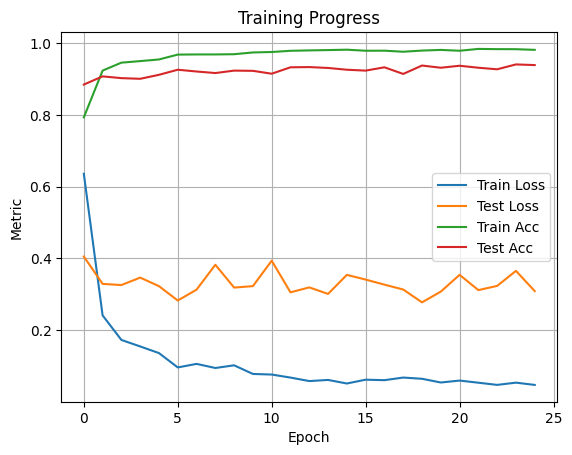

In [32]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.title("Training Progress - MNIST (6500)")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.grid()
plt.show()

In [33]:
final_preds = []

In [34]:
for i in range(0, len(X_test), batch_size):
    xb = X_test[i:i+batch_size]
    logits, _ = best_model.forward(xb, y_test[i:i+batch_size])
    preds = np.argmax(logits, axis=1)
    final_preds.extend(preds)

Confusion Matrix:


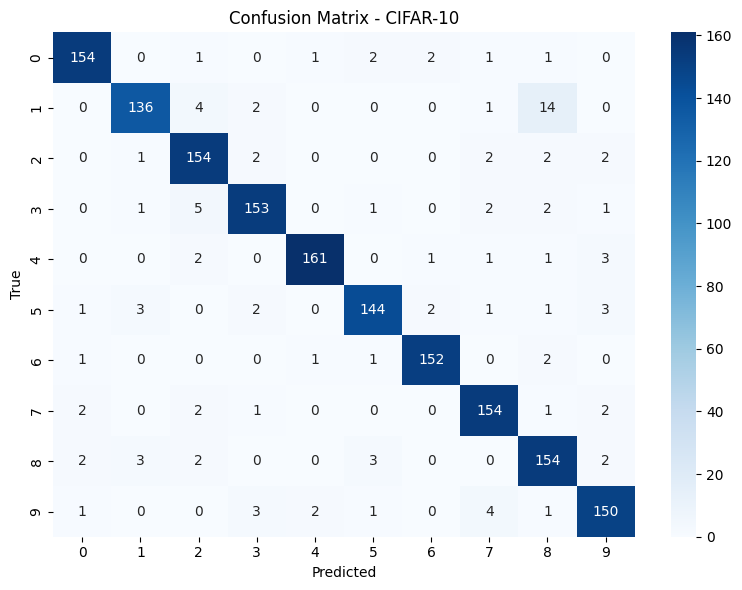

In [39]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test[:len(final_preds)], final_preds)
labels = [str(i) for i in range(10)]
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CIFAR-10")
plt.tight_layout()
plt.show()

In [40]:
print("Accuracy:", accuracy_score(y_test[:len(final_preds)], final_preds))
print("F1 Score:", f1_score(y_test[:len(final_preds)], final_preds, average='macro'))

Accuracy: 0.9333333333333333
F1 Score: 0.9334185104750231
